In [48]:
import sys
sys.path.append("..")

import Essentials


In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import Essentials
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from abc import ABC, abstractmethod

In [50]:
data_archive = np.load('C:\\Users\\misha\\Makarov\\Data_First_Nikita.npz', allow_pickle=True)

In [51]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp
ALL_column_names_1 = data_archive['column_names_1'] 
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat'] 
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.2, random_state=42)
y_train, timestamp_train = prepare_Y(y_train)
y_test, timestamp_test = prepare_Y(y_test)

In [52]:
x_test1, x_val, y_test1, y_val, timestamp_test1, timestamp_val = train_test_split(
    x_test, y_test, timestamp_test, test_size=0.5, random_state=42
)

In [53]:

class PLSSVDSoftSensor(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train, x_test, y_test, column_names, max_components=10):
        super().__init__(name)
        self.column_names = column_names
        self.r2_score = None
        self.best_n_components = None
        self.best_model = None
        self.train(x_train, y_train, x_test, y_test, max_components)

    def preprocessing(self, x):
        return x

    def postprocessing(self, y):
        return y

    def evaluate_model(self, x):
        return self.get_model().predict(x)

    def train(self, x_train, y_train, x_test, y_test, max_components):
        best_score = -np.inf
        best_n_components = 0

        for i in range(1, max_components + 1):
            model = PLSRegression(n_components=i, scale=False)
            model.fit(x_train, y_train)
            score = r2_score(y_test, model.predict(x_test))
            if score > best_score:
                best_score = score
                best_n_components = i
                self.best_model = model

        self.set_model(self.best_model)
        self.best_n_components = best_n_components
        self.r2_score = best_score

    def __str__(self):
        if self.get_model() is not None:
            # Находим длину самого длинного названия признака для выравнивания
            max_len = max(len(name) for name in self.column_names)
            
            # Подготавливаем строки коэффициентов с названиями признаков и выравниванием
            coefs_str = "\n".join(
                [f"{name.ljust(max_len)}: {coef:.4f}" for name, coef in zip(self.column_names, self.get_model().coef_.flatten())]
            )
            
            return (
                f"Модель PLSSVD с {self.best_n_components} компонентами: \n"
                f"Коэффициенты:\n{coefs_str} \n"  # Коэффициенты выводятся строкой с выравниванием
                f"R^2 (тестовая выборка): {self.r2_score:.4f}"  # Форматирование R^2 до 4 знаков после запятой
            )
        else:
            return "Модель PLSSVD еще не обучена."



In [54]:
Test_sensor_1 = PLSSVDSoftSensor("PLS Sensor", x_train, y_train, x_test, y_test, column_names= ALL_column_names_1, max_components=86)

In [55]:
print(Test_sensor_1)

Модель PLSSVD с 15 компонентами: 
Коэффициенты:
Расход бензина ККР на установку           : -0.0752
Расход нафты ККР на установку             : -0.0098
Расход бензина на рециркуляцию от Е-1205  : -0.0635
Температура бензина ККР на установку      : -0.0267
Расход сырья после Р-1101                 : 0.2470
Показатель соотношения водород к углероду : -0.0175
Расход водорода на смешение перед Е-1101  : -0.0233
Температура сырья перед Е-1101            : 0.0878
Давление сырья перед Е-1101               : -0.0088
Температура сырья перед Е-1102            : -0.1634
Температура сырья перед Е-1103            : 0.0878
Давление сырья перед Е-1103               : -0.0084
Температура сырья после Е-1103            : 0.1481
Температура ТБ перед Е-1101               : 0.1119
Температура ТБ после Е-1101               : -0.0973
Температура бензина перед Е-1102          : 0.1455
Температура бензина после Е-1102          : 0.0314
Давление бензина после Е-1102             : -0.0271
Температура пара перед 

In [56]:
metric = Essentials.R2Metric()

In [57]:
test_visual = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                      0.858033


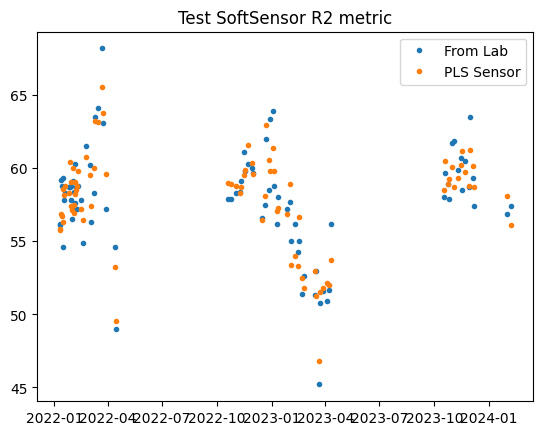

In [58]:
test_visual.visualize([Test_sensor_1])

In [59]:
test_visual_2 = Essentials.Visualizer(x_val, y_val, timestamp_val, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                      0.835277


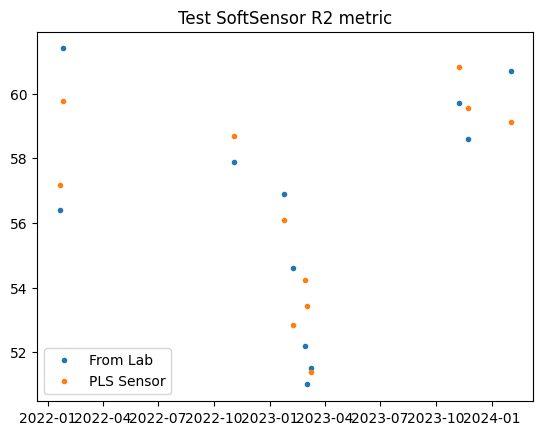

In [60]:
test_visual_2.visualize([Test_sensor_1])

In [61]:
test_visual_4 = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Test SoftSensor R2 metric')

            Coefficient of determination
PLS Sensor                      0.807084


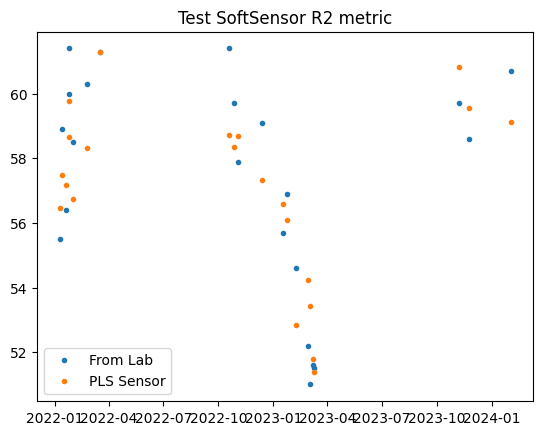

In [62]:
test_visual_4.visualize([Test_sensor_1])